In [1]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# TRTorch Getting Started - ResNet 50

## Overview

In the practice of developing machine learning models, there are few tools as approachable as PyTorch for developing and experimenting in designing machine learning models. The power of PyTorch comes from its deep integration into Python, its flexibility and its approach to automatic differentiation and execution (eager execution). However, when moving from research into production, the requirements change and we may no longer want that deep Python integration and we want optimization to get the best performance we can on our deployment platform. In PyTorch 1.0, TorchScript was introduced as a method to separate your PyTorch model from Python, make it portable and optimizable. TorchScript uses PyTorch's JIT compiler to transform your normal PyTorch code which gets interpreted by the Python interpreter to an intermediate representation (IR) which can have optimizations run on it and at runtime can get interpreted by the PyTorch JIT interpreter. For PyTorch this has opened up a whole new world of possibilities, including deployment in other languages like C++. It also introduces a structured graph based format that we can use to do down to the kernel level optimization of models for inference.

When deploying on NVIDIA GPUs TensorRT, NVIDIA's Deep Learning Optimization SDK and Runtime is able to take models from any major framework and specifically tune them to perform better on specific target hardware in the NVIDIA family be it an A100, TITAN V, Jetson Xavier or NVIDIA's Deep Learning Accelerator. TensorRT performs a couple sets of optimizations to achieve this. TensorRT fuses layers and tensors in the model graph, it then uses a large kernel library to select implementations that perform best on the target GPU. TensorRT also has strong support for reduced operating precision execution which allows users to leverage the Tensor Cores on Volta and newer GPUs as well as reducing memory and computation footprints on device.

TRTorch is a compiler that uses TensorRT to optimize TorchScript code, compiling standard TorchScript modules into ones that internally run with TensorRT optimizations. This enables you to continue to remain in the PyTorch ecosystem, using all the great features PyTorch has such as module composability, its flexible tensor implementation, data loaders and more. TRTorch is available to use with both PyTorch and LibTorch.

### Learning objectives

This notebook demonstrates the steps for compiling a TorchScript module with TRTorch on a pretrained ResNet-50 network, and running it to test the speedup obtained.

## Content
1. [Requirements](#1)
1. [ResNet-50 Overview](#2)
1. [Creating TorchScript modules](#3)
1. [Compiling with TRTorch](#4)
1. [Running Inference](#5)
1. [Measuring Speedup](#6)
1. [Conclusion](#7)

In [1]:
!nvidia-smi

Mon Aug 24 19:29:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.24       Driver Version: 450.24       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    34W / 300W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

<a id="1"></a>
## 1. Requirements

Follow the steps in `notebooks/README` to prepare a Docker container, within which you can run this notebook.

<a id="2"></a>
## 2. ResNet-50 Overview


PyTorch has a model repository called the PyTorch Hub, which is a source for high quality implementations of common models. We can get our ResNet-50 model from there pretrained on ImageNet.

### Model Description

This ResNet-50 model is based on the [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) paper, which describes ResNet as “a method for detecting objects in images using a single deep neural network". The input size is fixed to 32x32.

(More information about the ResNet-50 model is available at Nvidia's "[DeepLearningExamples](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Classification/ConvNets/resnet50v1.5)" Github.)




In [2]:
import torch

torch.hub.list('NVIDIA/DeepLearningExamples')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/master.zip" to /root/.cache/torch/hub/master.zip


['nvidia_ncf',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_waveglow',
 'relocated']

In [2]:
import torch

resnet50_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100.0%


In [3]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

!wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

--2020-08-24 19:29:46--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.227.77.5, 13.227.77.109, 13.227.77.154, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.227.77.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.001s  

2020-08-24 19:29:47 (44.4 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2020-08-24 19:29:48--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 23.185.0.4, 2620:12a:8001::4, 2620:12a:8000::4
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|23.185.0.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452718 (442K) [image/jp

In [4]:
# !pip install pillow matplotlib

     |████████████████████████████████| 11.6 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 26.0 MB/s eta 0:00:01
ERROR: matplotlib 3.3.1 has requirement pillow>=6.2.0, but you'll have pillow 4.3.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


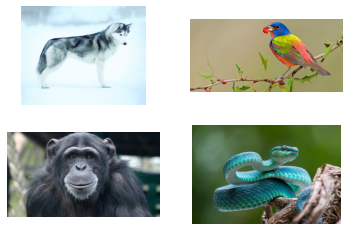

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = Image.open(img_path)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
  input_tensor = preprocess(img)      
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

In [15]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [19]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet50_model.to('cuda')

with torch.no_grad():
    output = resnet50_model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([-1.0941e+00, -3.0869e-01, -5.2834e-01, -1.0523e+00, -5.9791e-01,
        -2.5296e-01, -7.7640e-01,  5.3440e-01,  4.1246e-01, -4.7661e-01,
        -7.6271e-01, -7.7440e-01, -3.6173e-01, -8.5679e-01, -9.7189e-01,
        -4.4033e-01, -5.2238e-01, -7.0338e-02, -7.7410e-02, -3.6458e-01,
        -1.0817e+00, -6.5617e-01, -1.1831e+00, -9.8251e-02, -8.7666e-01,
        -7.5350e-01, -8.7502e-01, -7.1281e-01, -5.8139e-01, -3.1549e-01,
        -9.1589e-01, -8.6432e-01, -6.6319e-01, -5.4284e-01, -1.8587e-01,
        -6.2590e-01,  4.8753e-01, -6.6665e-01, -3.9458e-01,  1.6061e-01,
        -5.5537e-01, -8.0956e-01, -7.5005e-01, -3.2449e-01, -2.2420e-01,
        -4.6225e-01, -5.4693e-01, -4.1038e-01, -1.1333e+00, -7.1230e-01,
        -3.7442e-01,  3.6199e-01, -3.6375e-01, -4.0716e-01, -3.7833e-01,
        -1.0858e+00, -6.4781e-01, -1.1347e+00, -3.9610e-01, -1.4917e-01,
         6.8407e-01, -8.5677e-02, -1.6376e-01, -2.0467e-01, -7.9047e-01,
        -3.7820e-01, -4.8365e-01, -3.8252e-01, -7.9

In [22]:
# importing the module 
import json 
  
# Opening JSON file 
with open("./data/imagenet_class_index.json") as json_file: 
    d = json.load(json_file) 
print(len(d))
print(d)

1000
{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n016327

In [23]:
import numpy as np
# from torchvision.utils import imagenet_classes


for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = Image.open(img_path)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
  input_tensor = preprocess(img)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet50_model.to('cuda')

  with torch.no_grad():
    output = resnet50_model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
  sm_output = torch.nn.functional.softmax(output[0], dim=0)
  print(output.shape)
#   print(output[0])
  ind = torch.argmax(sm_output)
  print("ind", ind)
  print(sm_output[ind])
  print(d[str(ind.item())])
  print()



#   x = np.array(input_tensor)
#   x = np.expand_dims(x, axis=0)

#   preds = resnet50_model.predict(x)

  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)



#   print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

#   plt.subplot(2,2,i+1)
#   plt.imshow(img);
#   plt.axis('off');
#   plt.title(imagenet_classes(preds, top=3)[0][0][1])

torch.Size([1, 1000])
ind tensor(600, device='cuda:0')
tensor(0.0055, device='cuda:0')
['n03532672', 'hook']

torch.Size([1, 1000])
ind tensor(600, device='cuda:0')
tensor(0.0062, device='cuda:0')
['n03532672', 'hook']

torch.Size([1, 1000])
ind tensor(463, device='cuda:0')
tensor(0.0059, device='cuda:0')
['n02909870', 'bucket']

torch.Size([1, 1000])
ind tensor(463, device='cuda:0')
tensor(0.0059, device='cuda:0')
['n02909870', 'bucket']



### Benchmark utility

Let us define a helper function to benchmark a model.

In [4]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%100==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [5]:
# Model benchmark without TRTorch/TensorRT
model = resnet50_model.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 224, 224), nruns=1000)

Warm up ...
Start timing ...
Iteration 100/1000, ave batch time 162.82 ms
Iteration 200/1000, ave batch time 162.91 ms
Iteration 300/1000, ave batch time 162.94 ms
Iteration 400/1000, ave batch time 162.96 ms
Iteration 500/1000, ave batch time 162.97 ms
Iteration 600/1000, ave batch time 162.97 ms
Iteration 700/1000, ave batch time 162.97 ms
Iteration 800/1000, ave batch time 162.98 ms
Iteration 900/1000, ave batch time 162.98 ms
Iteration 1000/1000, ave batch time 162.98 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 162.98 ms


<a id="3"></a>
## 3. Creating TorchScript modules

To compile with TRTorch, the model must first be in **TorchScript**. TorchScript is a programming language included in PyTorch which removes the Python dependency normal PyTorch models have. This conversion is done via a JIT compiler which given a PyTorch Module will generate an equivalent TorchScript Module. There are two paths that can be used to generate TorchScript: **Tracing** and **Scripting**. Tracing follows execution of PyTorch generating ops in TorchScript corresponding to what it sees. Scripting does an analysis of the Python code and generates TorchScript, this allows the resulting graph to include control flow which tracing cannot do. Tracing however due to its simplicity is more likely to compile successfully with TRTorch (though both systems are supported). 

In [7]:
model = resnet50_model.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((128, 3, 224, 224)).to("cuda")])

We can save this model and use it independently of Python.

In [8]:
# This is just an example, and not required for the purposes of this demo
torch.jit.save(traced_model, "resnet_50_traced.jit.pt")

In [ ]:
# Obtain the average time taken by a batch of input
benchmark(traced_model, input_shape=(128, 3, 224, 224), nruns=1000)

<a id="4"></a>
## 4. Compiling with TRTorch

TorchScript modules behave just like normal PyTorch modules and are intercompatable. From TorchScript we can now compile a TensorRT based module. This module will still be implemented in TorchScript but all the computation will be done in TensorRT.

In [ ]:
import trtorch

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model = trtorch.compile(traced_model, {
    "input_shapes": [(128, 3, 224, 224)],
    "op_precision": torch.half, # Run with FP16
    "workspace_size": 1 << 20
})


In [ ]:
# Obtain the average time taken by a batch of input
benchmark(trt_model, input_shape=(128, 3, 224, 224), dtype='fp16', nruns=1000)

In [19]:
import trtorch

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model_fp32 = trtorch.compile(traced_model, {
    "input_shapes": [(128, 3, 224, 224)],
    "op_precision": torch.float32, # Run with FP32
    "workspace_size": 1 << 20
})



In [20]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp32, input_shape=(128, 3, 224, 224), nruns=1000)

Warm up ...
Start timing ...
Iteration 100/1000, ave batch time 119.81 ms
Iteration 200/1000, ave batch time 119.83 ms
Iteration 300/1000, ave batch time 119.87 ms
Iteration 400/1000, ave batch time 119.99 ms
Iteration 500/1000, ave batch time 120.08 ms
Iteration 600/1000, ave batch time 120.19 ms
Iteration 700/1000, ave batch time 120.24 ms
Iteration 800/1000, ave batch time 120.30 ms
Iteration 900/1000, ave batch time 120.35 ms
Iteration 1000/1000, ave batch time 114.07 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average batch time: 114.07 ms


<a id="5"></a>
## 5. Running Inference

We can now run inference on the TRTorch compiled model. This is demonstrated below using sample images from the COCO 2017 Validation set.

In [9]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [10]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([-9.4537e-02, -1.4596e+00, -1.1330e+00, -1.6520e+00, -2.8367e+00,
         2.5034e-01, -1.0562e+00,  3.0290e+00,  4.8499e+00,  1.4322e-01,
        -3.0074e+00, -1.2253e+00, -1.7812e+00, -2.6095e+00, -2.7430e+00,
        -1.6470e+00, -6.3207e-01,  1.2096e+00, -1.2136e-01, -1.0899e+00,
        -2.0130e+00, -6.3550e-01, -5.5107e-01,  1.1292e+00, -1.7935e+00,
        -4.5523e-01, -6.1320e-01, -6.3687e-01, -1.0281e+00,  1.1140e+00,
        -1.1821e+00, -9.3301e-01, -6.6413e-01, -2.8717e+00, -2.2735e+00,
        -1.1740e+00, -1.2014e+00, -1.5959e+00, -2.8250e+00, -5.8934e-01,
        -3.9307e-01, -2.6001e+00, -1.5767e+00, -2.5568e+00,  5.8025e-01,
        -2.1373e+00, -5.2948e-01, -1.5152e+00, -2.4959e+00, -1.1388e+00,
         1.6644e-01, -4.5050e-01,  1.6418e-01,  2.7721e-01, -1.1867e+00,
        -9.4941e-01, -1.2710e+00, -9.4497e-01, -5.2795e-01, -5.3808e-01,
         1.5079e+00, -1.5966e+00, -2.4035e+00, -1.5511e+00, -3.0469e+00,
        -2.0768e+00, -9.0381e-01, -9.8416e-01, -1.1

In [54]:
# # !pip uninstall torchvision
# # !/usr/bin/python -m pip install --upgrade pip

# !pip install torch===1.6.0 torchvision===0.4.1 -f https://download.pytorch.org/whl/torch_stable.html
# # !pip install torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 10.1 MB 5.3 MB/s eta 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

torchvision 0.4.1 requires torch==1.3.0, but you'll have torch 1.6.0 which is incompatible.


In [30]:
# Sample images from the COCO validation set
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Format images to comply with the network input
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)

# The model was trained on COCO dataset, which we need to access in order to
# translate class IDs into object names. 
classes_to_labels = utils.get_coco_object_dictionary()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip


ModuleNotFoundError: No module named 'skimage'

In [11]:
benchmark(model)

Warm up ...
Start timing ...
Iteration 1000/10000, ave batch time 0.93 ms
Iteration 2000/10000, ave batch time 0.93 ms
Iteration 3000/10000, ave batch time 0.93 ms
Iteration 4000/10000, ave batch time 0.93 ms
Iteration 5000/10000, ave batch time 0.93 ms
Iteration 6000/10000, ave batch time 0.93 ms
Iteration 7000/10000, ave batch time 0.93 ms
Iteration 8000/10000, ave batch time 0.93 ms
Iteration 9000/10000, ave batch time 0.93 ms
Iteration 10000/10000, ave batch time 0.93 ms
Input shape: torch.Size([1024, 1, 32, 32])
Output features size: torch.Size([1024, 10])
Average batch time: 0.93 ms


When compiling your module to TorchScript, there are two paths: Tracing and Scripting.  
 
### Tracing

Tracing follows the path of execution when the module is called and records what happens. This recording is what the TorchScript IR will describe. To trace an instance of our LeNet module, we can call torch.jit.trace  with an example input. 

In [12]:
traced_model = torch.jit.trace(model, torch.empty([1,1,32,32]).to("cuda"))
traced_model

LeNet(
  original_name=LeNet
  (feat): LeNetFeatExtractor(
    original_name=LeNetFeatExtractor
    (conv1): Conv2d(original_name=Conv2d)
    (conv2): Conv2d(original_name=Conv2d)
  )
  (classifer): LeNetClassifier(
    original_name=LeNetClassifier
    (fc1): Linear(original_name=Linear)
    (fc2): Linear(original_name=Linear)
    (fc3): Linear(original_name=Linear)
  )
)

In [13]:
benchmark(traced_model)

Warm up ...
Start timing ...
Iteration 1000/10000, ave batch time 0.68 ms
Iteration 2000/10000, ave batch time 0.68 ms
Iteration 3000/10000, ave batch time 0.68 ms
Iteration 4000/10000, ave batch time 0.68 ms
Iteration 5000/10000, ave batch time 0.68 ms
Iteration 6000/10000, ave batch time 0.68 ms
Iteration 7000/10000, ave batch time 0.68 ms
Iteration 8000/10000, ave batch time 0.68 ms
Iteration 9000/10000, ave batch time 0.68 ms
Iteration 10000/10000, ave batch time 0.68 ms
Input shape: torch.Size([1024, 1, 32, 32])
Output features size: torch.Size([1024, 10])
Average batch time: 0.68 ms


### Scripting

Scripting actually inspects your code with a compiler and  generates an equivalent TorchScript program. The difference is that since tracing simply follows the execution of your module, it cannot pick up control flow for instance, it will only follow the code path that a particular input triggers. By working from the Python code, the compiler can include these components. We can run the script compiler on our LeNet  module by calling torch.jit.script.


In [14]:
model = LeNet().to("cuda").eval()
script_model = torch.jit.script(model)


In [15]:
script_model

RecursiveScriptModule(
  original_name=LeNet
  (feat): RecursiveScriptModule(
    original_name=LeNetFeatExtractor
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (conv2): RecursiveScriptModule(original_name=Conv2d)
  )
  (classifer): RecursiveScriptModule(
    original_name=LeNetClassifier
    (fc1): RecursiveScriptModule(original_name=Linear)
    (fc2): RecursiveScriptModule(original_name=Linear)
    (fc3): RecursiveScriptModule(original_name=Linear)
  )
)

In [16]:
benchmark(script_model)

Warm up ...
Start timing ...
Iteration 1000/10000, ave batch time 0.68 ms
Iteration 2000/10000, ave batch time 0.68 ms
Iteration 3000/10000, ave batch time 0.68 ms
Iteration 4000/10000, ave batch time 0.68 ms
Iteration 5000/10000, ave batch time 0.68 ms
Iteration 6000/10000, ave batch time 0.68 ms
Iteration 7000/10000, ave batch time 0.68 ms
Iteration 8000/10000, ave batch time 0.68 ms
Iteration 9000/10000, ave batch time 0.68 ms
Iteration 10000/10000, ave batch time 0.68 ms
Input shape: torch.Size([1024, 1, 32, 32])
Output features size: torch.Size([1024, 10])
Average batch time: 0.68 ms


<a id="3"></a>
## 3. Compiling with TRTorch

### TorchScript traced model

First, we compile the TorchScript traced model with TRTorch. Notice the performance impact.

In [17]:
import trtorch

compile_settings = {
    "input_shapes": [
        {
            "min" : [1, 1, 32, 32],
            "opt" : [1, 1, 33, 33],
            "max" : [1, 1, 34, 34],
        }
    ],
    "op_precision": torch.half # Run with FP16
}

trt_ts_module = trtorch.compile(traced_model, compile_settings)

input_data = torch.randn((1, 1, 32, 32))
input_data = input_data.half().to("cuda")

input_data = input_data.half()
result = trt_ts_module(input_data)
torch.jit.save(trt_ts_module, "trt_ts_module.ts")

In [18]:
benchmark(trt_ts_module, dtype="fp16")

Warm up ...
Start timing ...
Iteration 1000/10000, ave batch time 0.24 ms
Iteration 2000/10000, ave batch time 0.24 ms
Iteration 3000/10000, ave batch time 0.24 ms
Iteration 4000/10000, ave batch time 0.24 ms
Iteration 5000/10000, ave batch time 0.24 ms
Iteration 6000/10000, ave batch time 0.24 ms
Iteration 7000/10000, ave batch time 0.23 ms
Iteration 8000/10000, ave batch time 0.23 ms
Iteration 9000/10000, ave batch time 0.23 ms
Iteration 10000/10000, ave batch time 0.23 ms
Input shape: torch.Size([1024, 1, 32, 32])
Output features size: torch.Size([1, 10])
Average batch time: 0.23 ms


### TorchScript script model

Next, we compile the TorchScript script model with TRTorch. Notice the performance impact.

In [19]:
import trtorch

compile_settings = {
    "input_shapes": [
        {
            "min" : [1, 1, 32, 32],
            "opt" : [1, 1, 33, 33],
            "max" : [1, 1, 34, 34],
        }
    ],
    "op_precision": torch.half # Run with FP16
}

trt_script_module = trtorch.compile(script_model, compile_settings)

input_data = torch.randn((1, 1, 32, 32))
input_data = input_data.half().to("cuda")

input_data = input_data.half()
result = trt_script_module(input_data)
torch.jit.save(trt_script_module, "trt_script_module.ts")

In [20]:
benchmark(trt_ts_module, dtype="fp16")

Warm up ...
Start timing ...
Iteration 1000/10000, ave batch time 0.20 ms
Iteration 2000/10000, ave batch time 0.20 ms
Iteration 3000/10000, ave batch time 0.20 ms
Iteration 4000/10000, ave batch time 0.21 ms
Iteration 5000/10000, ave batch time 0.21 ms
Iteration 6000/10000, ave batch time 0.21 ms
Iteration 7000/10000, ave batch time 0.21 ms
Iteration 8000/10000, ave batch time 0.21 ms
Iteration 9000/10000, ave batch time 0.21 ms
Iteration 10000/10000, ave batch time 0.21 ms
Input shape: torch.Size([1024, 1, 32, 32])
Output features size: torch.Size([1, 10])
Average batch time: 0.21 ms


## Conclusion

In this notebook, we have walked through the complete process of compiling TorchScript models with TRTorch and test the performance impact of the optimization.

### What's next
Now it's time to try TRTorch on your own model. Fill out issues at https://github.com/NVIDIA/TRTorch. Your involvement will help future development of TRTorch.
